## Assignment 10: Exploring Fine-Tuning in Classification

### Stefenie Pickston
#### 1506427

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

classes = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cls = os.path.join(dirname, filename).split('/')[6]
        if cls not in classes:
            classes.append(cls)
print(classes)

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['beetle', 'spider', 'road', 'orchid', 'motorcycle', 'orange', 'cattle', 'fox', 'wolf', 'turtle', 'snake', 'shark', 'cloud', 'hamster', 'mountain', 'bus', 'boy', 'skunk', 'clock', 'chimpanzee', 'tank', 'can', 'dinosaur', 'lawn_mower', 'butterfly', 'man', 'lion', 'lobster', 'otter', 'television', 'apple', 'raccoon', 'plain', 'telephone', 'oak_tree', 'skyscraper', 'flatfish', 'bear', 'cup', 'bee', 'trout', 'wardrobe', 'sweet_pepper', 'caterpillar', 'rocket', 'tractor', 'whale', 'pear', 'mouse', 'tiger', 'lizard', 'plate', 'lamp', 'porcupine', 'kangaroo', 'poppy', 'willow_tree', 'bed', 'house', 'worm', 'keyboard', 'aquarium_fish', 'possum', 'beaver', 'pickup_truck', 'elephant', 'baby', 'snail', 'castle', 'seal', 'mushroom', 'bridge', 'woman', 'bicycle', 'streetcar', 'rabbit', 'crab', 'girl', 'chair', 'sea', 'palm_tree', 'dolphin', 'camel', 'maple_tree', 'squirrel', 'leopard', 'cockroach', 'forest', 'crocodile', 'bowl', 'sunflower', 'tulip', 'bottle', 'couch', 'rose', 'ray', 'train', 'shre

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

#### Preparing the Data

In [13]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_dataset(directory, classes, image_size=(32,32), verbose=0):
    dataset=[]
    class_id=0
    for name in classes:
        if verbose>0:
            print(f'Processing {name}') # For debugging purposes, since this method takes a while to complete
        path=os.path.join(directory,name)
        for im in os.listdir(path):
            if im[-4:]=='.png':
                image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=image_size)
                image=img_to_array(image)
                image=image/255.0
                dataset.append([image, class_id])
        class_id=class_id+1
    data,labels0=zip(*dataset)
    data=np.array(data)
    labels1=to_categorical(labels0)
    labels=np.array(labels1)
    return (data, labels)

# train test validation split stuff
train_data,train_labels=load_dataset("/kaggle/input/cifar100/CIFAR100/TRAIN/", classes, image_size=(32, 32))
test_data,test_labels=load_dataset("/kaggle/input/cifar100/CIFAR100/TEST/", classes, image_size=(32, 32))
val_data,val_labels=load_dataset("/kaggle/input/cifar100/CIFAR100/VALID/", classes, image_size=(32, 32))

Prep to log test accuracy

In [14]:
# use callback to log test accuracy
from tensorflow.keras.callbacks import Callback
class LogTestAccuracy(Callback):
    def on_epoch_end(self, epoch, logs):
        logs['test_accuracy'] = self.model.evaluate(test_data, test_labels)[1]

Loading and Training the model

In [15]:
# define the pretrained model, freeze layers in the loop
pretrained_model = tf.keras.applications.MobileNet(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
for layers in pretrained_model.layers:
    layers.trainable=False
    
# connect one 100 unit for each class predictor head to output of pretrained network
predictor_head = tf.keras.layers.Dense(100, activation='softmax')(pretrained_model.output)

# define model
pretrained_inputs = pretrained_model.input
model = tf.keras.Model(inputs=pretrained_inputs, outputs=predictor_head)

In [16]:
# train frozen model for 10 epochs
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=10,  callbacks=[LogTestAccuracy()], batch_size=256)

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5461 - accuracy: 0.0275
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4972 - accuracy: 0.0349
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4631 - accuracy: 0.0385
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4380 - accuracy: 0.0427
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4190 - accuracy: 0.0439
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 4.4044 - accuracy: 0.0447
Epoch 7/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3928 - accuracy: 0.0470
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3833 - accuracy: 0.0469
Epoch 9/10
313/313 [==============================] - 2s 7ms/step - loss: 4.3756 - accuracy: 0.0478
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3691 - accuracy: 0.0488

Unfreeze and train for 30 epochs. 

In [17]:
# unfreeze
for layers in pretrained_model.layers:
    layers.trainable=True

# train for 30 epochs
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=30,  callbacks=[LogTestAccuracy()], batch_size=256)

Epoch 1/30
313/313 [==============================] - 2s 6ms/step - loss: 5.6792 - accuracy: 0.0843
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 2.8290 - accuracy: 0.2958
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 2.5065 - accuracy: 0.3758
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 2.4512 - accuracy: 0.4045
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 2.5124 - accuracy: 0.4164
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 2.5164 - accuracy: 0.4259
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 2.5827 - accuracy: 0.4229
Epoch 8/30
313/313 [==============================] - 2s 8ms/step - loss: 2.8553 - accuracy: 0.4275
Epoch 9/30
313/313 [==============================] - 2s 6ms/step - loss: 2.6918 - accuracy: 0.4435
Epoch 10/30
313/313 [==============================] - 2s 6ms/step - loss: 2.7269 - accuracy: 0.4458

Plotting accuracy learning curves. 

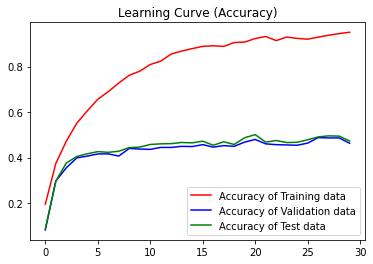

<Figure size 432x288 with 0 Axes>

In [18]:
# plotting the train, validation and test accuracies
import matplotlib.pyplot as plt

train_acc=history.history['accuracy']    
val_acc=history.history['val_accuracy']    
test_acc=history.history['test_accuracy']    
epochs = range(len(train_acc))
plt.plot(train_acc, 'r', label='Accuracy of Training data')
plt.plot(val_acc, 'b', label='Accuracy of Validation data')
plt.plot(test_acc, 'g', label='Accuracy of Test data')
plt.title('Learning Curve (Accuracy)')
plt.legend(loc=0)
plt.figure()
plt.show()

Experiments with SGD and Adam

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6175 - accuracy: 0.0111
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6063 - accuracy: 0.0109
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5961 - accuracy: 0.0120
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5869 - accuracy: 0.0121
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5785 - accuracy: 0.0163
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5707 - accuracy: 0.0185
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 4.5634 - accuracy: 0.0186
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5566 - accuracy: 0.0206
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5502 - accuracy: 0.0211
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5441 - accuracy: 0.0226

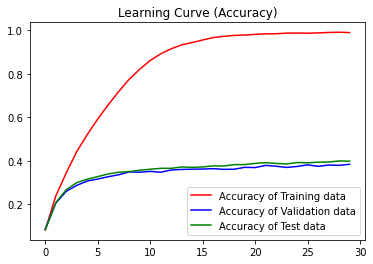

<Figure size 432x288 with 0 Axes>

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6150 - accuracy: 0.0110
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6148 - accuracy: 0.0111
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6147 - accuracy: 0.0111
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6145 - accuracy: 0.0111
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6144 - accuracy: 0.0111
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6142 - accuracy: 0.0111
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6141 - accuracy: 0.0111
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6139 - accuracy: 0.0111
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6138 - accuracy: 0.0111
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6136 - accuracy: 0.0111

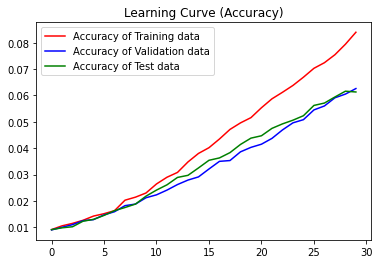

<Figure size 432x288 with 0 Axes>

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5394 - accuracy: 0.0244
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4929 - accuracy: 0.0325
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4600 - accuracy: 0.0392
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4357 - accuracy: 0.0410
Epoch 5/10
313/313 [==============================] - 2s 7ms/step - loss: 4.4173 - accuracy: 0.0436
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 4.4032 - accuracy: 0.0442
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 4.3917 - accuracy: 0.0454
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3826 - accuracy: 0.0463
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 4.3750 - accuracy: 0.0467
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss: 4.3688 - accuracy: 0.0488

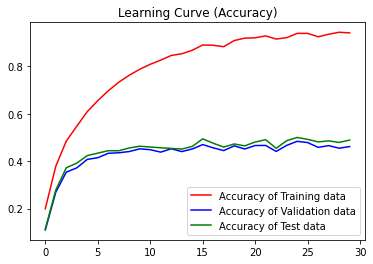

<Figure size 432x288 with 0 Axes>

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6147 - accuracy: 0.0081
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6133 - accuracy: 0.0093
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6120 - accuracy: 0.0095
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6107 - accuracy: 0.0105
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6095 - accuracy: 0.0113
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6083 - accuracy: 0.0120
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6071 - accuracy: 0.0126
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6060 - accuracy: 0.0133
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6049 - accuracy: 0.0139
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss: 4.6038 - accuracy: 0.0141

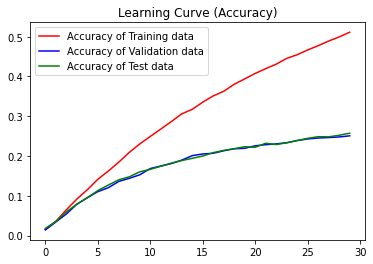

<Figure size 432x288 with 0 Axes>

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 4.4164 - accuracy: 0.0426
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3704 - accuracy: 0.0476
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3518 - accuracy: 0.0481
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3419 - accuracy: 0.0498
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3346 - accuracy: 0.0496
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3308 - accuracy: 0.0527
Epoch 7/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3265 - accuracy: 0.0531
Epoch 8/10
313/313 [==============================] - 2s 7ms/step - loss: 4.3262 - accuracy: 0.0499
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 4.3243 - accuracy: 0.0503
Epoch 10/10
313/313 [==============================] - 2s 7ms/step - loss: 4.3239 - accuracy: 0.0524

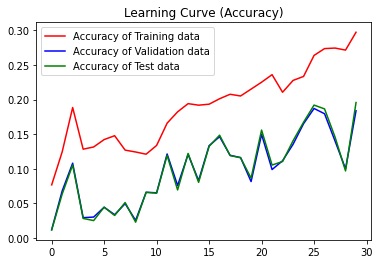

<Figure size 432x288 with 0 Axes>

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6137 - accuracy: 0.0090
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6073 - accuracy: 0.0109
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 4.6016 - accuracy: 0.0134
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5966 - accuracy: 0.0147
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 4.5920 - accuracy: 0.0161
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5879 - accuracy: 0.0172
Epoch 7/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5841 - accuracy: 0.0190
Epoch 8/10
313/313 [==============================] - 2s 7ms/step - loss: 4.5806 - accuracy: 0.0198
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 4.5772 - accuracy: 0.0207
Epoch 10/10
313/313 [==============================] - 2s 8ms/step - loss: 4.5741 - accuracy: 0.0208

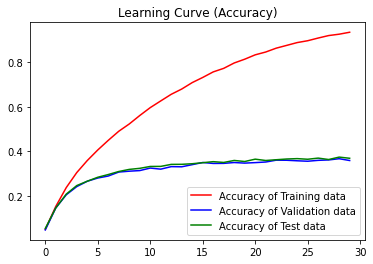

<Figure size 432x288 with 0 Axes>

In [19]:
import tensorflow as tf
# array to store values
accuracies = []
best_val_acc = 0
best_model = None

# functions to run multiple times
def run_optimizers(optimizers,l_rate):
    pretrained_model = tf.keras.applications.MobileNet(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
    for layers in pretrained_model.layers:
        layers.trainable=False
        
    predictor_head = tf.keras.layers.Dense(100, activation='softmax')(pretrained_model.output)

    pretrained_inputs = pretrained_model.input
    model = tf.keras.Model(inputs=pretrained_inputs, outputs=predictor_head)
    model.compile(optimizer=optimizers(learning_rate=l_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    history=model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=10,  callbacks=[LogTestAccuracy()], batch_size=256)
    
    # unfreeze
    for layers in pretrained_model.layers:
        layers.trainable=True
    model.compile(optimizer=optimizers(learning_rate=l_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    history=model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=30,  callbacks=[LogTestAccuracy()], batch_size=256)
    
    # finding the best model, the best validation accuracy = best model
    global best_val_acc, best_model
    if history.history['val_accuracy'][-1] > best_val_acc:
        best_val_acc = history.history['val_accuracy'][-1]
        best_model = model
    
    return history

def plotting(history):
    train_acc=history.history['accuracy']    
    val_acc=history.history['val_accuracy']    
    test_acc=history.history['test_accuracy']
    
    epochs = range(len(train_acc))
    plt.plot(train_acc, 'r', label='Accuracy of Training data')
    plt.plot(val_acc, 'b', label='Accuracy of Validation data')
    plt.plot(test_acc, 'g', label='Accuracy of Test data')
    plt.title('Learning Curve (Accuracy)')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
learning_rates = [0.0001, 0.001, 0.005]
optimizer_type = [tf.keras.optimizers.Adam,tf.keras.optimizers.SGD]

# run the six experiments
for i in learning_rates:
    for j in optimizer_type:
        accuracies.append(j)
        accuracies.append(i)
        
        history = run_optimizers(j,i)
        accuracies.append(history.history['accuracy'][-1]) 
        accuracies.append(history.history['val_accuracy'][-1]) 
        accuracies.append(history.history['test_accuracy'][-1])
        
        plotting(history)

In [20]:
# creating a table
from tabulate import tabulate
# reshape data
series_obj = pd.Series(accuracies)
arr = series_obj.values
reshaped_acc = arr.reshape((6,5)) 
# create header
head = ["Optimizer", "Training Rate", "Training Accuracy", "Validation Accuracy", "Test Accuracy"] 
# display table
print(tabulate(reshaped_acc, headers=head, tablefmt="grid"))
#reshaped_acc

+---------------------------------------------------+-----------------+---------------------+-----------------------+-----------------+
| Optimizer                                         |   Training Rate |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+===================================================+=================+=====================+=======================+=================+
| <class 'keras.optimizer_v2.adam.Adam'>            |          0.0001 |            0.988875 |                0.3844 |          0.3984 |
+---------------------------------------------------+-----------------+---------------------+-----------------------+-----------------+
| <class 'keras.optimizer_v2.gradient_descent.SGD'> |          0.0001 |            0.08395  |                0.0626 |          0.0613 |
+---------------------------------------------------+-----------------+---------------------+-----------------------+-----------------+
| <class 'keras.optimizer_v2.adam.Adam'>        

For the overall best of the six run, for each of the 100 classes identify the worst misclassification in the test set.

"Worst" is defined as the maximum value for p[predicted]-p[correct].

Plot these 100 examples, each with a title that includes the correct label and its probability, and the wrongly predicted label and its probability. E.g.:  "correct:Dog 0.21, predicted:Cat 0.53"

In [27]:
# testing the best model
print(best_val_acc)
y_pred = best_model.predict(test_data)
y_pred

0.46129998564720154


array([[8.6471234e-03, 4.1165623e-07, 4.7148191e-08, ..., 6.6736185e-09,
        1.4937743e-08, 3.0869156e-08],
       [8.5300982e-01, 6.9062560e-07, 5.5702517e-12, ..., 1.6050797e-05,
        8.1963067e-09, 6.9976802e-11],
       [6.6489238e-01, 2.1241844e-04, 1.6541772e-08, ..., 8.5981355e-07,
        1.6983007e-06, 1.2352437e-07],
       ...,
       [9.6235181e-14, 1.9944216e-13, 5.8437963e-11, ..., 1.8584946e-13,
        8.6635192e-17, 9.9993098e-01],
       [2.2959024e-07, 1.2286890e-05, 2.0023346e-05, ..., 9.6848218e-09,
        5.3149898e-07, 8.5869098e-01],
       [1.1644838e-08, 3.1641815e-08, 1.6667628e-06, ..., 5.8374159e-09,
        3.2736114e-10, 3.8185948e-01]], dtype=float32)

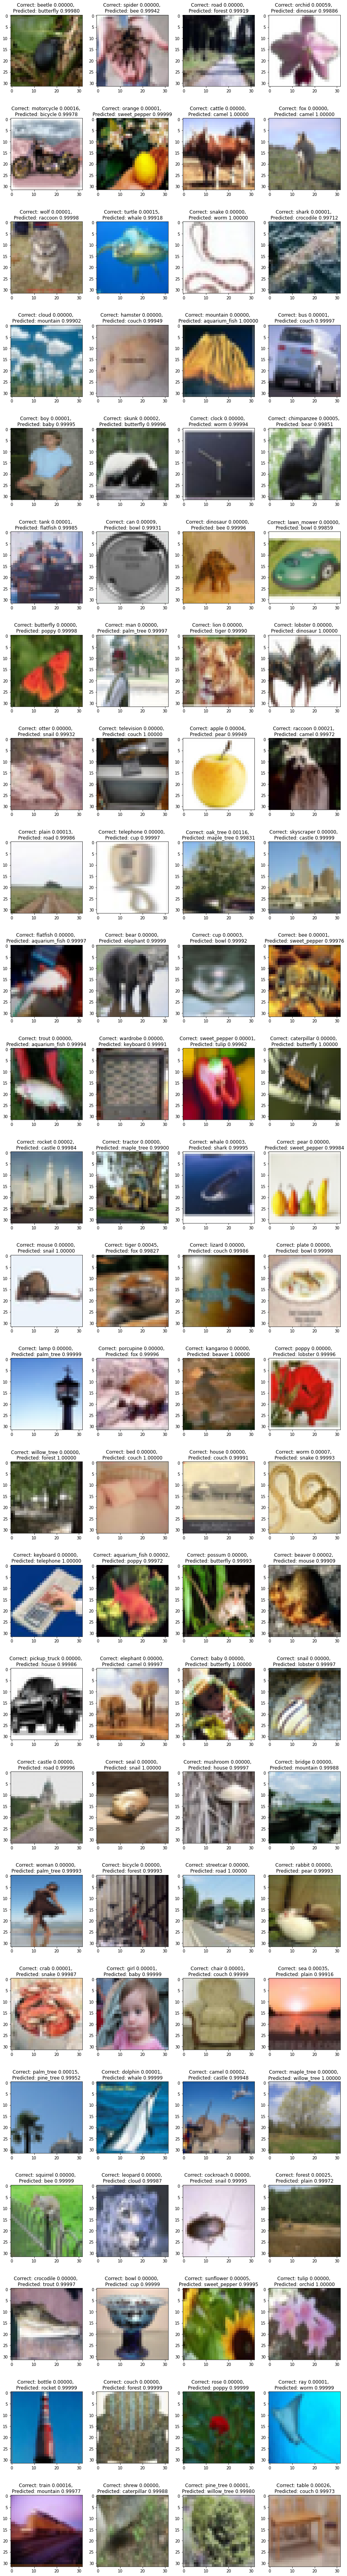

In [43]:
# creating the test set classifications
# test_set_classifications := look at test_labels and pick out the rows that has 1 in the column corresponding to the class

# dictionary
predictions = []

for i in range(len(y_pred)):
    correct_class = test_labels[i].tolist().index(1) # get correct index
    predicted_class = y_pred[i].tolist().index(max(y_pred[i])) # get max index
    
    #print(y_pred[i][correct_class], y_pred[i][predicted_class])
    
    predictions.append({
        'correct_name': classes[correct_class],
        'correct_prob': y_pred[i][correct_class],
        'predicted_name': classes[predicted_class],
        'predicted_prob': y_pred[i][predicted_class],
        'misprediction_score': y_pred[i][predicted_class] - y_pred[i][correct_class],
        'image_id': i    
        })

def plot_img(i, row, column, ax):
    # find worst misclassification
    class_preds = [pred for pred in predictions if pred['correct_name'] == classes[i]]
    worst = max(class_preds, key=lambda x:x['misprediction_score'])
    
    #print(worst)
    
    # plot the worst
    ax[row, column].set_title("Correct: {} {:.5f}, \nPredicted: {} {:.5f}".format(worst['correct_name'], worst['correct_prob'], worst['predicted_name'], worst['predicted_prob']))
    ax[row, column].imshow(test_data[worst['image_id']])
    
fig, ax = plt.subplots(25, 4, figsize=(15, 120))
i = 0
for row in range(25):
    for col in range(4):
        plot_img(i, row, col, ax)
        i += 1